In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image

#### Loading Dataset from Hugging Face

In [11]:
from datasets import load_dataset

# loading dataset from Hugging Face Hub
dataset = load_dataset("nateraw/kitti", split='train')

# saving on disk
dataset.save_to_disk("./HF_Kitti")

# loading from disk
dataset = dataset.load_from_disk("./HF_Kitti")

README.md:   0%|          | 0.00/522 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

(…)-00000-of-00013-5723231dc9089e69.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

(…)-00001-of-00013-b52779cd1a3373bc.parquet:   0%|          | 0.00/473M [00:00<?, ?B/s]

(…)-00002-of-00013-8c8e262101e51529.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

(…)-00003-of-00013-12a4796322673e2d.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

(…)-00004-of-00013-a879c3bd90955658.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

(…)-00005-of-00013-c57f3dcdebe9a144.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

(…)-00006-of-00013-b31d221b64c456d7.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

(…)-00007-of-00013-5a3d950f3c58f3d6.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

(…)-00008-of-00013-4499890ec50dfa8f.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

(…)-00009-of-00013-3022ba0812def0cf.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

(…)-00010-of-00013-e2ae866098584411.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

(…)-00011-of-00013-6afb75c8a28a2a58.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]


KeyboardInterrupt



## Data Visualization For Inspecting Dataset

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to visualize an image with bounding boxes and additional label information
def visualize_image_with_boxes(dataset, index):
    """
    Visualizes an image with its corresponding bounding boxes and label information.

    Parameters:
        dataset (list): List of dataset entries containing images and labels.
        index (int): The index of the image to visualize.
    """
    # Get the image and corresponding labels
    image = dataset[index]['image']
    labels = dataset[index]['label']  # Assume labels is a list of dictionaries

    # Create a larger figure for better visibility
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis('off')  # Turn off axes
    plt.title(f'Image {index + 1}')

    # Check and plot bounding boxes along with other label info
    for label in labels:
        # Access the bounding box coordinates
        box = label['bbox']  # [x_min, y_min, x_max, y_max]

        # Extract coordinates
        x_min, y_min, x_max, y_max = box

        # Create a rectangle patch for the bounding box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor='red', facecolor='none')
        plt.gca().add_patch(rect)

        # Add object type label
        plt.text(x_min, y_min - 10, label['type'], color='red', fontsize=12, weight='bold')

        # Add occlusion status
        occlusion_text = 'Occluded' if label['occluded'] > 0 else 'Visible'
        plt.text(x_min, y_min - 25, occlusion_text, color='orange', fontsize=10)

        # Optionally add dimensions as text
        dimensions_text = f'Dimensions: {label["dimensions"]}'
        plt.text(x_min, y_min - 40, dimensions_text, color='blue', fontsize=10)

        # Optional: Visualize rotation (as an arrow)
        # Note: This is a basic representation. You may want to scale/rotate the arrow based on actual rotation.
        rotation_angle = label['rotation_y']
        arrow_length = 20  # Adjust as necessary
        plt.arrow(x_min + (x_max - x_min) / 2, y_min + (y_max - y_min) / 2,
                  arrow_length * np.cos(rotation_angle), arrow_length * np.sin(rotation_angle),
                  head_width=3, head_length=3, fc='green', ec='green')

    plt.show()

# Example usage: Visualize the first image in the dataset
visualize_image_with_boxes(dataset, 0)  # Change the index to visualize other images


## Converting Kitti to Yolo Format

In [ ]:
import os
from pathlib import Path
import yaml
from tqdm.auto import tqdm
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
from functools import partial

class KITTItoYOLOFast:
    def __init__(self, dataset, output_path):
        self.dataset = dataset
        self.output_path = Path(output_path)
        
        # Create class mapping from KITTI classes (do this once)
        self.classes = self._get_unique_classes()
        self.class_to_id = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Create directories
        self._create_directories()
    
    def _get_unique_classes(self):
        """Extract unique classes using set comprehension"""
        classes = {obj['type'] for data in self.dataset for obj in data['label']}
        return sorted(list(classes))
    
    def _create_directories(self):
        """Create directory structure"""
        for split in ['train', 'val']:
            (self.output_path / 'images' / split).mkdir(parents=True, exist_ok=True)
            (self.output_path / 'labels' / split).mkdir(parents=True, exist_ok=True)
    
    @staticmethod
    def convert_bbox_to_yolo(bbox, img_width, img_height):
        """Vectorized bbox conversion"""
        x_min, y_min, x_max, y_max = bbox
        
        x_center = (x_min + x_max) / (2.0 * img_width)
        y_center = (y_min + y_max) / (2.0 * img_height)
        width = (x_max - x_min) / img_width
        height = (y_max - y_min) / img_height
        
        return [x_center, y_center, width, height]
    
    def process_single_item(self, args):
        """Process a single dataset item"""
        idx, is_train = args
        data = self.dataset[idx]
        subset = 'train' if is_train else 'val'
        
        # Define paths
        image_path = self.output_path / 'images' / subset / f'{idx:06d}.png'
        label_path = self.output_path / 'labels' / subset / f'{idx:06d}.txt'
        
        # Save image
        data['image'].save(str(image_path))
        
        # Process annotations
        labels = []
        for obj in data['label']:
            class_id = self.class_to_id[obj['type']]
            yolo_bbox = self.convert_bbox_to_yolo(
                obj['bbox'],
                data['image'].width,
                data['image'].height
            )
            labels.append(f"{class_id} {' '.join([f'{x:.6f}' for x in yolo_bbox])}")
        
        # Write all labels at once
        with open(label_path, 'w') as f:
            f.write('\n'.join(labels))
        
        return idx
    
    def convert_dataset(self, train_split=0.8, num_workers=None):
        """
        Convert dataset using parallel processing
        
        Args:
            train_split: Fraction of data for training
            num_workers: Number of parallel workers (default: CPU count - 1)
        """
        if num_workers is None:
            num_workers = max(1, multiprocessing.cpu_count() - 1)
        
        # Prepare indices
        num_samples = len(self.dataset)
        num_train = int(num_samples * train_split)
        indices = np.random.permutation(num_samples)
        train_indices = set(indices[:num_train])
        
        # Prepare arguments for parallel processing
        process_args = [(idx, idx in train_indices) for idx in range(num_samples)]
        
        # Process in parallel with progress bar
        with ThreadPoolExecutor(max_workers=num_workers) as executor:
            futures = [executor.submit(self.process_single_item, arg) for arg in process_args]
            
            with tqdm(total=num_samples, desc="Converting dataset") as pbar:
                for future in as_completed(futures):
                    future.result()  # Get the result to ensure no exceptions are lost
                    pbar.update(1)
        
        # Create data.yaml file
        self._create_yaml()
    
    def _create_yaml(self):
        """Create YOLO data.yaml file"""
        data = {
            'path': str(self.output_path.absolute()),
            'train': str(self.output_path / 'images' / 'train'),
            'val': str(self.output_path / 'images' / 'val'),
            'nc': len(self.classes),
            'names': self.classes
        }
        
        with open(self.output_path / 'data.yaml', 'w') as f:
            yaml.dump(data, f, sort_keys=False)


In [ ]:
# Example usage with performance monitoring
if __name__ == "__main__":
    import time
    
    output_path = "Kitti_Yolo"
    
    start_time = time.time()
    
    # Initialize and convert
    converter = KITTItoYOLOFast(dataset, output_path)
    
    # Use maximum available workers (CPU count - 1)
    converter.convert_dataset(num_workers=4)
    
    end_time = time.time()
    print(f"Conversion completed in {end_time - start_time:.2f} seconds")

In [ ]:
import yaml


output_path = "/kaggle/working/Kitti_Yolo"

# Load data.yaml file
with open(os.path.join(output_path, 'data.yaml'), 'r') as f:
    data_config = yaml.safe_load(f)

train_path = data_config['train']
val_path = data_config['val']
class_names = data_config['names']


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def load_yolo_labels(label_file):
    """Load YOLO format labels from a text file."""
    bboxes = []
    with open(label_file, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])
            bbox = list(map(float, parts[1:]))
            bboxes.append((class_id, bbox))
    return bboxes

def draw_bboxes(image, bboxes):
    """Draw bounding boxes on the image."""
    for class_id, bbox in bboxes:
        x_center, y_center, width, height = bbox
        img_height, img_width, _ = image.shape
        
        # Calculate the box coordinates
        x_min = int((x_center - width / 2) * img_width)
        y_min = int((y_center - height / 2) * img_height)
        x_max = int((x_center + width / 2) * img_width)
        y_max = int((y_center + height / 2) * img_height)
        
        # Draw rectangle
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        # Optionally add class id text
        cv2.putText(image, str(class_id), (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return image

def visualize_samples(num_samples=5, subset='train'):
    """Visualize samples from the dataset."""
    # Get the path to the images and labels
    image_folder = Path(output_path) / 'images' / subset
    label_folder = Path(output_path) / 'labels' / subset
    
    # List image files
    image_files = list(image_folder.glob('*.png'))
    
    # Randomly sample images
    sampled_files = np.random.choice(image_files, size=min(num_samples, len(image_files)), replace=False)
    
    for image_file in sampled_files:
        # Load image
        image = cv2.imread(str(image_file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
        
        # Load corresponding label file
        label_file = label_folder / (image_file.stem + '.txt')
        
        if not label_file.exists():
            print(f"Warning: Label file {label_file} does not exist. Skipping this image.")
            continue
        
        bboxes = load_yolo_labels(label_file)
        
        # Draw bounding boxes
        image_with_bboxes = draw_bboxes(image, bboxes)
        
        # Create a new figure for each image
        plt.figure(figsize=(12, 8))
        plt.imshow(image_with_bboxes)
        plt.axis('off')
        plt.title(image_file.name)
        plt.show()

# Example usage
output_path = "/kaggle/working/Kitti_Yolo"
visualize_samples(num_samples=5, subset='train')


## Data Processing

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from pathlib import Path
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
import logging
import warnings

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class YOLODataset(Dataset):
    def __init__(self, img_dir, label_dir, img_size=640, augment=True, min_visibility=0.1):
        """
        Custom Dataset for YOLO object detection.
        
        Args:
            img_dir (str): Path to images directory
            label_dir (str): Path to labels directory
            img_size (int): Input image size (default: 640)
            augment (bool): Whether to apply data augmentation
            min_visibility (float): Minimum visibility threshold for boxes
        """
        self.img_dir = Path(img_dir)
        self.label_dir = Path(label_dir)
        self.img_size = img_size
        self.min_visibility = min_visibility
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        
        # Set up augmentations with careful bbox handling
        if augment:
            self.transform = A.Compose([
                A.RandomResizedCrop(
                    img_size, img_size,
                    scale=(0.8, 1.0),
                    ratio=(0.8, 1.2),
                    always_apply=True
                ),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ], bbox_params=A.BboxParams(
                format='yolo',
                label_fields=['class_labels'],
                min_visibility=min_visibility
            ))
        else:
            self.transform = A.Compose([
                A.Resize(img_size, img_size, always_apply=True),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ], bbox_params=A.BboxParams(
                format='yolo',
                label_fields=['class_labels'],
                min_visibility=min_visibility
            ))

    def __len__(self):
        return len(self.img_files)

    @staticmethod
    def validate_bbox(box):
        """
        Validate and clean YOLO format bbox coordinates.
        Returns None if box is invalid, otherwise returns cleaned box.
        """
        try:
            x_center, y_center, width, height = box
            
            # Basic range checks
            if not (0 <= x_center <= 1 and 0 <= y_center <= 1):
                return None
                
            # Check for zero or negative dimensions
            if width <= 0 or height <= 0:
                return None
                
            # Check for unreasonably large dimensions
            if width > 1 or height > 1:
                return None
                
            # Calculate box coordinates
            x_min = x_center - width/2
            y_min = y_center - height/2
            x_max = x_center + width/2
            y_max = y_center + height/2
            
            # Check if box is completely outside image
            if x_min > 1 or y_min > 1 or x_max < 0 or y_max < 0:
                return None
                
            # Clip coordinates and recalculate dimensions
            x_min = np.clip(x_min, 0, 1)
            y_min = np.clip(y_min, 0, 1)
            x_max = np.clip(x_max, 0, 1)
            y_max = np.clip(y_max, 0, 1)
            
            # Recalculate center and dimensions
            new_x_center = (x_min + x_max) / 2
            new_y_center = (y_min + y_max) / 2
            new_width = x_max - x_min
            new_height = y_max - y_min
            
            # Final size check
            if new_width * new_height < 1e-6:  # Minimum area threshold
                return None
                
            return [new_x_center, new_y_center, new_width, new_height]
            
        except Exception as e:
            logger.warning(f"Error validating bbox: {e}")
            return None

    def __getitem__(self, idx):
        try:
            # Load image
            img_path = self.img_dir / self.img_files[idx]
            img = np.array(Image.open(img_path).convert('RGB'))
            
            # Check image validity
            if img.size == 0 or len(img.shape) != 3:
                raise ValueError("Invalid image")
            
            # Load labels
            label_path = self.label_dir / f"{self.img_files[idx].split('.')[0]}.txt"
            
            boxes = []
            class_labels = []
            
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f.readlines():
                        try:
                            data = line.strip().split()
                            if len(data) == 5:
                                class_id = int(data[0])
                                box = [float(x) for x in data[1:]]
                                
                                # Validate and clean bbox
                                cleaned_box = self.validate_bbox(box)
                                if cleaned_box is not None:
                                    boxes.append(cleaned_box)
                                    class_labels.append(class_id)
                                
                        except (ValueError, IndexError) as e:
                            continue
            
            # Convert to numpy arrays
            if boxes:
                boxes = np.array(boxes, dtype=np.float32)
                class_labels = np.array(class_labels)
                
                # Filter out boxes with zero area or invalid dimensions
                valid_mask = (boxes[:, 2] > 0) & (boxes[:, 3] > 0) & (boxes[:, 2] <= 1) & (boxes[:, 3] <= 1)
                boxes = boxes[valid_mask]
                class_labels = class_labels[valid_mask]
            else:
                boxes = np.zeros((0, 4), dtype=np.float32)
                class_labels = np.array([], dtype=np.int64)
            
            # Suppress warnings during transformation
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=RuntimeWarning)
                
                if len(boxes) > 0:
                    transformed = self.transform(
                        image=img,
                        bboxes=boxes,
                        class_labels=class_labels
                    )
                    img = transformed['image']
                    boxes = torch.tensor(transformed['bboxes'], dtype=torch.float32)
                    class_labels = torch.tensor(transformed['class_labels'], dtype=torch.long)
                else:
                    transformed = self.transform(image=img)
                    img = transformed['image']
                    boxes = torch.zeros((0, 4), dtype=torch.float32)
                    class_labels = torch.zeros(0, dtype=torch.long)
            
            return {
                'image': img,
                'boxes': boxes,
                'labels': class_labels,
                'img_path': str(img_path)
            }
            
        except Exception as e:
            logger.error(f"Error processing {self.img_files[idx]}: {str(e)}")
            # Return a valid but empty sample
            img = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)
            transformed = self.transform(image=img)
            return {
                'image': transformed['image'],
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros(0, dtype=torch.long),
                'img_path': str(img_path)
            }

def create_dataloaders(train_img_dir, train_label_dir, 
                      val_img_dir, val_label_dir,
                      batch_size=16, img_size=640, num_workers=4,
                      min_visibility=0.1):
    """
    Create training and validation dataloaders
    
    Args:
        train_img_dir (str): Path to training images
        train_label_dir (str): Path to training labels
        val_img_dir (str): Path to validation images
        val_label_dir (str): Path to validation labels
        batch_size (int): Batch size
        img_size (int): Input image size
        num_workers (int): Number of worker processes
        min_visibility (float): Minimum visibility threshold for boxes
    
    Returns:
        tuple: (train_loader, val_loader)
    """
    train_dataset = YOLODataset(
        train_img_dir,
        train_label_dir,
        img_size=img_size,
        augment=True,
        min_visibility=min_visibility
    )
    
    val_dataset = YOLODataset(
        val_img_dir,
        val_label_dir,
        img_size=img_size,
        augment=False,
        min_visibility=min_visibility
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=collate_fn
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=collate_fn
    )
    
    return train_loader, val_loader

def collate_fn(batch):
    """
    Custom collate function to handle variable number of objects per image
    """
    images = []
    boxes = []
    labels = []
    img_paths = []
    
    for b in batch:
        images.append(b['image'])
        boxes.append(b['boxes'])
        labels.append(b['labels'])
        img_paths.append(b['img_path'])
    
    images = torch.stack(images)
    
    return {
        'images': images,
        'boxes': boxes,
        'labels': labels,
        'img_paths': img_paths
    }

In [ ]:
# Create dataloaders
train_loader, val_loader = create_dataloaders(
    train_img_dir='/kaggle/working/Kitti_Yolo/images/train',
    train_label_dir='/kaggle/working/Kitti_Yolo/labels/train',
    val_img_dir='/kaggle/working/Kitti_Yolo/images/val',
    val_label_dir='/kaggle/working/Kitti_Yolo/labels/val',
    batch_size=16,
    img_size=640,
    num_workers=4
)


In [ ]:
# Example of iterating through the dataloader
for batch in train_loader:
    images = batch['images']  # Shape: [batch_size, 3, img_size, img_size]
    boxes = batch['boxes']    # List of tensors, each with shape [num_objects, 4]
    labels = batch['labels']  # List of tensors, each with shape [num_objects]
    
    break

## Model

In [3]:
!pip install ultralytics
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 11.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 2.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.5 MB/s eta 0:00:0000:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages 

In [4]:
import wandb
wandb.login(key="f198231eb74aafd6fb917133b6c23825a3c490fe")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Training Loop

In [26]:
!pip install -U ultralytics wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 49.7 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.18.3
    Uninstalling wandb-0.18.3:
      Successfully uninstalled wandb-0.18.3


### Training Loop

In [10]:
from dataclasses import dataclass, asdict
from ultralytics import YOLO  # Adding the import that was missing

@dataclass
class Config:
    data: str
    model_size: str
    model_name: str
    epochs: int
    batch_size: int
    img_size: int
    patience: int
    save: bool
    project: str
    exist_ok: bool
    val: bool
    plots: bool
    save_period: int

class Trainer:
    """
    Trainer class for YOLO model training.
    """

    def __init__(self, config: Config):
        """
        Initialize the Trainer class.

        Args:
            config (Config): Configuration instance.
        """
        self.config = config
        self.model = YOLO("yolo11n.pt")

    def train(self):
        """
        Train the YOLO model using the configuration parameters.
        Converts the config dataclass to a dictionary of training arguments.
        """
        try:
            # Convert config to dictionary and remove model-specific attributes
            train_args = asdict(self.config)
            # Remove attributes that aren't training parameters
            train_args.pop('model_size')
            train_args.pop('model_name')

            # Train the model with unpacked arguments
            self.model.train(
                data=train_args['data'],
                epochs=train_args['epochs'],
                batch=train_args['batch_size'],
                imgsz=train_args['img_size'],
                patience=train_args['patience'],
                project=train_args['project'],
                exist_ok=train_args['exist_ok'],
                val=train_args['val'],
                plots=train_args['plots'],
                save_period=train_args['save_period'],
                save=train_args['save']
            )
            print("Model training completed successfully.")
        except Exception as e:
            print(f"Error during model training: {str(e)}")
            raise  # Re-raise the exception for proper error handling

def main():
    # Define model size
    model_size = "n"  # Options: "n", "s", "m", "l", "x"

    # Configuration instance
    config = Config(
        data="/kaggle/working/Kitti_Yolo/data.yaml",
        model_size=model_size,
        model_name=f"yolo11{model_size}",
        epochs=100,
        batch_size=32,
        img_size=640,
        patience=50,
        save=True,
        project="Yolo11n_obj",
        exist_ok=True,
        val=True,
        plots=True,
        save_period=10
    )

    trainer = Trainer(config)
    trainer.train()

if __name__ == "__main__":
    main()

Ultralytics 8.3.27 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/Kitti_Yolo/data.yaml, epochs=100, time=None, patience=50, batch=32, imgsz=640, save=True, save_period=10, cache=False, device=None, workers=8, project=Yolo11n_obj, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show

100%|██████████| 755k/755k [00:00<00:00, 19.7MB/s]


Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/Kitti_Yolo/labels/train.cache... 5984 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5984/5984 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/Kitti_Yolo/labels/val.cache... 1497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1497/1497 [00:00<?, ?it/s]


Plotting labels to Yolo11n_obj/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to Yolo11n_obj/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.02G      1.536      2.249      1.115        431        640: 100%|██████████| 187/187 [01:32<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.68it/s]


                   all       1497      10486      0.452      0.284      0.259      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.99G      1.376      1.331       1.08        492        640: 100%|██████████| 187/187 [01:30<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.13it/s]


                   all       1497      10486      0.391      0.365      0.346      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.98G       1.33      1.193      1.069        467        640: 100%|██████████| 187/187 [01:29<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.15it/s]


                   all       1497      10486      0.525      0.378      0.406      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.08G      1.317      1.108      1.066        439        640: 100%|██████████| 187/187 [01:28<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


                   all       1497      10486      0.519       0.42       0.44      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.95G      1.287      1.028      1.054        454        640: 100%|██████████| 187/187 [01:28<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.50it/s]


                   all       1497      10486      0.525      0.457      0.473      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.94G      1.251     0.9742      1.043        430        640: 100%|██████████| 187/187 [01:29<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


                   all       1497      10486      0.632      0.482      0.529      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.93G      1.235     0.9401       1.04        547        640: 100%|██████████| 187/187 [01:28<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.51it/s]


                   all       1497      10486      0.629      0.481      0.535      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.96G      1.217     0.9093      1.033        452        640: 100%|██████████| 187/187 [01:28<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.37it/s]


                   all       1497      10486      0.622      0.514       0.56      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.97G      1.197     0.8821      1.024        529        640: 100%|██████████| 187/187 [01:29<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.34it/s]


                   all       1497      10486      0.676      0.512      0.577      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.97G      1.189     0.8667       1.02        451        640: 100%|██████████| 187/187 [01:27<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


                   all       1497      10486      0.647      0.521      0.579      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.95G       1.18     0.8562      1.019        457        640: 100%|██████████| 187/187 [01:28<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.51it/s]


                   all       1497      10486      0.621      0.549      0.586      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.94G      1.167      0.834      1.013        457        640: 100%|██████████| 187/187 [01:28<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


                   all       1497      10486      0.645      0.544      0.588      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.98G      1.149     0.8194      1.004        453        640: 100%|██████████| 187/187 [01:28<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]


                   all       1497      10486      0.664      0.545      0.605      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.97G      1.152      0.813      1.006        530        640: 100%|██████████| 187/187 [01:28<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


                   all       1497      10486      0.746      0.568      0.639      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.01G      1.136     0.7965      1.003        485        640: 100%|██████████| 187/187 [01:28<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.22it/s]


                   all       1497      10486      0.754      0.549      0.644      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.95G      1.124     0.7903     0.9981        426        640: 100%|██████████| 187/187 [01:27<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.25it/s]


                   all       1497      10486      0.662      0.598      0.654      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.88G       1.11     0.7724     0.9912        471        640: 100%|██████████| 187/187 [01:27<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.27it/s]


                   all       1497      10486      0.688      0.609       0.66      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.93G      1.106     0.7649     0.9924        396        640: 100%|██████████| 187/187 [01:29<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.35it/s]


                   all       1497      10486      0.803      0.588      0.678      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.93G      1.102     0.7622     0.9897        376        640: 100%|██████████| 187/187 [01:28<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.52it/s]


                   all       1497      10486      0.752       0.59      0.678       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.94G      1.094     0.7483     0.9853        445        640: 100%|██████████| 187/187 [01:29<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.56it/s]


                   all       1497      10486       0.72      0.614      0.692      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.95G      1.085     0.7479     0.9856        437        640: 100%|██████████| 187/187 [01:28<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


                   all       1497      10486       0.71       0.61      0.682      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.92G      1.075     0.7321     0.9787        361        640: 100%|██████████| 187/187 [01:27<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.28it/s]


                   all       1497      10486      0.789      0.623      0.706      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.96G      1.071     0.7292     0.9794        486        640: 100%|██████████| 187/187 [01:28<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.58it/s]


                   all       1497      10486      0.731      0.638      0.699      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.97G       1.07     0.7239     0.9764        494        640: 100%|██████████| 187/187 [01:29<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


                   all       1497      10486      0.691      0.662      0.711       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.97G      1.059     0.7162     0.9727        428        640: 100%|██████████| 187/187 [01:28<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.22it/s]


                   all       1497      10486      0.725      0.643      0.712      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         5G      1.057     0.7103     0.9733        432        640: 100%|██████████| 187/187 [01:29<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.20it/s]


                   all       1497      10486      0.767       0.65      0.726      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.75G      1.053     0.7055     0.9704        378        640: 100%|██████████| 187/187 [01:28<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.18it/s]


                   all       1497      10486      0.786      0.638      0.719      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.84G      1.044      0.703     0.9679        507        640: 100%|██████████| 187/187 [01:28<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.24it/s]


                   all       1497      10486      0.732       0.66       0.72      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.01G      1.031     0.6884     0.9614        511        640: 100%|██████████| 187/187 [01:30<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.50it/s]


                   all       1497      10486      0.798      0.641      0.729      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.93G      1.035     0.6919     0.9656        414        640: 100%|██████████| 187/187 [01:29<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.59it/s]


                   all       1497      10486      0.765      0.655      0.727      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.95G      1.025     0.6832     0.9605        445        640: 100%|██████████| 187/187 [01:28<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.28it/s]


                   all       1497      10486      0.776      0.661      0.733      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.95G      1.019     0.6778     0.9606        405        640: 100%|██████████| 187/187 [01:28<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.20it/s]


                   all       1497      10486      0.753      0.677      0.745      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.84G      1.016      0.673     0.9601        427        640: 100%|██████████| 187/187 [01:30<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]


                   all       1497      10486      0.757      0.688      0.745      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.97G      1.014     0.6715      0.957        536        640: 100%|██████████| 187/187 [01:31<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.67it/s]


                   all       1497      10486      0.797      0.671      0.742      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.01G      1.004     0.6621      0.956        533        640: 100%|██████████| 187/187 [01:29<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.61it/s]


                   all       1497      10486      0.836      0.648      0.749      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.96G      1.001     0.6616     0.9545        439        640: 100%|██████████| 187/187 [01:30<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]


                   all       1497      10486      0.777      0.701      0.758      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.92G          1     0.6593     0.9531        349        640: 100%|██████████| 187/187 [01:28<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.52it/s]


                   all       1497      10486      0.776       0.71      0.762      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.99G     0.9921     0.6528      0.953        409        640: 100%|██████████| 187/187 [01:29<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]


                   all       1497      10486      0.781        0.7       0.76       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.97G     0.9889     0.6494     0.9497        392        640: 100%|██████████| 187/187 [01:28<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.57it/s]


                   all       1497      10486       0.78      0.708      0.771      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.19G     0.9832     0.6442      0.948        435        640: 100%|██████████| 187/187 [01:28<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


                   all       1497      10486      0.754      0.711      0.768      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.98G     0.9806     0.6437     0.9474        423        640: 100%|██████████| 187/187 [01:29<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.60it/s]


                   all       1497      10486      0.801      0.695      0.769       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.98G     0.9784     0.6405     0.9451        467        640: 100%|██████████| 187/187 [01:28<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.58it/s]


                   all       1497      10486      0.749      0.735      0.776      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.91G      0.973     0.6376     0.9438        479        640: 100%|██████████| 187/187 [01:28<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.48it/s]


                   all       1497      10486       0.75       0.73      0.773      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       5.2G     0.9677     0.6313     0.9419        411        640: 100%|██████████| 187/187 [01:27<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.13it/s]


                   all       1497      10486      0.779      0.714      0.776      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.97G     0.9675     0.6297      0.941        407        640: 100%|██████████| 187/187 [01:28<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.38it/s]


                   all       1497      10486       0.75      0.733      0.783      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.94G     0.9567     0.6242     0.9393        408        640: 100%|██████████| 187/187 [01:28<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.20it/s]


                   all       1497      10486      0.779      0.729      0.782      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.95G     0.9568     0.6228     0.9388        427        640: 100%|██████████| 187/187 [01:28<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.19it/s]


                   all       1497      10486      0.791      0.721      0.778      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.94G     0.9533     0.6199     0.9376        480        640: 100%|██████████| 187/187 [01:28<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


                   all       1497      10486      0.769      0.735      0.784      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.94G     0.9435      0.614     0.9354        504        640: 100%|██████████| 187/187 [01:29<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


                   all       1497      10486      0.791      0.721      0.785      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.83G     0.9445     0.6096     0.9327        449        640: 100%|██████████| 187/187 [01:27<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.14it/s]


                   all       1497      10486      0.797       0.73      0.789      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.77G     0.9401     0.6068     0.9324        491        640: 100%|██████████| 187/187 [01:27<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.24it/s]

                   all       1497      10486      0.802      0.732      0.791      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.04G     0.9417     0.6086     0.9338        430        640: 100%|██████████| 187/187 [01:28<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.60it/s]

                   all       1497      10486      0.774      0.738      0.787      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.99G     0.9341     0.6045     0.9294        491        640: 100%|██████████| 187/187 [01:28<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.08it/s]


                   all       1497      10486      0.814      0.726      0.792      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.84G     0.9321     0.6025      0.929        370        640: 100%|██████████| 187/187 [01:28<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


                   all       1497      10486      0.821      0.732      0.797      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         5G      0.929     0.5985     0.9294        402        640: 100%|██████████| 187/187 [01:28<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.51it/s]


                   all       1497      10486      0.852      0.716      0.799      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         5G     0.9286     0.6005     0.9292        490        640: 100%|██████████| 187/187 [01:29<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.37it/s]


                   all       1497      10486      0.816      0.737      0.804       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.94G      0.921     0.5959     0.9268        425        640: 100%|██████████| 187/187 [01:28<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.56it/s]


                   all       1497      10486      0.776      0.743      0.796      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.94G     0.9212     0.5924     0.9262        419        640: 100%|██████████| 187/187 [01:28<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


                   all       1497      10486      0.834      0.717      0.795      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.95G     0.9158     0.5881     0.9253        456        640: 100%|██████████| 187/187 [01:27<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.37it/s]

                   all       1497      10486      0.795      0.737      0.802      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.96G     0.9126     0.5851     0.9241        411        640: 100%|██████████| 187/187 [01:28<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]


                   all       1497      10486      0.819      0.753      0.804      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.86G     0.9125     0.5865     0.9233        471        640: 100%|██████████| 187/187 [01:28<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]


                   all       1497      10486      0.802      0.749      0.804       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       4.9G     0.9034     0.5812       0.92        443        640: 100%|██████████| 187/187 [01:29<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.64it/s]


                   all       1497      10486       0.84      0.734      0.804      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.76G     0.9015     0.5789       0.92        396        640: 100%|██████████| 187/187 [01:29<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.29it/s]


                   all       1497      10486      0.823      0.747       0.81      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.92G     0.8988     0.5774     0.9197        381        640: 100%|██████████| 187/187 [01:28<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.25it/s]


                   all       1497      10486      0.823      0.736      0.808      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.83G     0.8978     0.5739     0.9169        530        640: 100%|██████████| 187/187 [01:28<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.36it/s]


                   all       1497      10486      0.837      0.733      0.806      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.99G        0.9      0.576     0.9181        435        640: 100%|██████████| 187/187 [01:28<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]

                   all       1497      10486      0.823      0.752      0.808      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.85G      0.889     0.5678     0.9177        514        640: 100%|██████████| 187/187 [01:27<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]

                   all       1497      10486      0.819      0.756       0.81      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.92G      0.887     0.5687     0.9149        389        640: 100%|██████████| 187/187 [01:26<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]


                   all       1497      10486      0.833      0.747      0.811      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.75G     0.8809     0.5665     0.9155        401        640: 100%|██████████| 187/187 [01:29<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.39it/s]

                   all       1497      10486      0.835      0.743      0.812      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.91G     0.8805     0.5614     0.9139        311        640: 100%|██████████| 187/187 [01:27<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.59it/s]

                   all       1497      10486      0.836      0.744      0.816      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.98G     0.8769     0.5605     0.9132        484        640: 100%|██████████| 187/187 [01:27<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.40it/s]

                   all       1497      10486      0.798      0.766      0.812      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         5G     0.8744     0.5579     0.9094        426        640: 100%|██████████| 187/187 [01:27<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]


                   all       1497      10486      0.803      0.769      0.816      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.04G     0.8728     0.5542     0.9119        476        640: 100%|██████████| 187/187 [01:27<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.58it/s]


                   all       1497      10486      0.819      0.759      0.815       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.94G      0.868      0.553     0.9105        442        640: 100%|██████████| 187/187 [01:27<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.04it/s]


                   all       1497      10486      0.804      0.765      0.814      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.97G     0.8622     0.5516     0.9068        427        640: 100%|██████████| 187/187 [01:27<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.73it/s]


                   all       1497      10486      0.831      0.755      0.818      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.89G     0.8643     0.5511       0.91        454        640: 100%|██████████| 187/187 [01:27<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.36it/s]


                   all       1497      10486      0.811      0.768      0.819      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.96G     0.8636     0.5523      0.909        415        640: 100%|██████████| 187/187 [01:27<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.48it/s]

                   all       1497      10486      0.812      0.755      0.816      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.92G     0.8635     0.5487     0.9078        401        640: 100%|██████████| 187/187 [01:27<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.58it/s]

                   all       1497      10486      0.826       0.75      0.816      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.93G     0.8588     0.5456     0.9057        522        640: 100%|██████████| 187/187 [01:28<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.81it/s]

                   all       1497      10486      0.845      0.741      0.816      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       4.9G     0.8583     0.5463      0.907        471        640: 100%|██████████| 187/187 [01:29<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.12it/s]

                   all       1497      10486      0.839      0.748      0.817      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.93G     0.8521     0.5417      0.905        391        640: 100%|██████████| 187/187 [01:28<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.60it/s]


                   all       1497      10486      0.816      0.759      0.819      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.99G     0.8506     0.5426     0.9058        403        640: 100%|██████████| 187/187 [01:28<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.67it/s]

                   all       1497      10486       0.79       0.77      0.816      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.93G     0.8443     0.5379     0.9034        481        640: 100%|██████████| 187/187 [01:29<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.50it/s]


                   all       1497      10486      0.803       0.77      0.818      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.97G     0.8422     0.5377     0.9015        454        640: 100%|██████████| 187/187 [01:27<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.43it/s]

                   all       1497      10486      0.811      0.772      0.819      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.02G     0.8457     0.5362     0.9016        546        640: 100%|██████████| 187/187 [01:28<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.62it/s]

                   all       1497      10486      0.832      0.762       0.82      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.97G     0.8392     0.5328     0.9003        392        640: 100%|██████████| 187/187 [01:29<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


                   all       1497      10486      0.853      0.748      0.819      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.95G      0.835     0.5309     0.8998        460        640: 100%|██████████| 187/187 [01:30<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.75it/s]

                   all       1497      10486      0.808      0.763      0.817      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.04G     0.8323     0.5295     0.8995        461        640: 100%|██████████| 187/187 [01:28<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]

                   all       1497      10486      0.838      0.756      0.823      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.96G     0.8312      0.527     0.8995        476        640: 100%|██████████| 187/187 [01:29<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.48it/s]


                   all       1497      10486      0.796      0.781       0.82      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.96G     0.8346     0.5291     0.8997        493        640: 100%|██████████| 187/187 [01:28<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.61it/s]


                   all       1497      10486      0.814      0.763       0.82      0.593
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.67G     0.8241     0.5134     0.8926        227        640: 100%|██████████| 187/187 [01:31<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.57it/s]


                   all       1497      10486      0.843       0.75      0.818      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       4.6G     0.8048     0.5004     0.8881        192        640: 100%|██████████| 187/187 [01:27<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]

                   all       1497      10486      0.827      0.761      0.819      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.63G      0.793     0.4949     0.8842        227        640: 100%|██████████| 187/187 [01:25<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]

                   all       1497      10486      0.834      0.759      0.819       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.66G     0.7871     0.4923     0.8834        245        640: 100%|██████████| 187/187 [01:25<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


                   all       1497      10486      0.837      0.758       0.82      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.63G     0.7809     0.4878     0.8802        204        640: 100%|██████████| 187/187 [01:25<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.71it/s]

                   all       1497      10486      0.827      0.771      0.821      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.69G     0.7807     0.4871     0.8826        195        640: 100%|██████████| 187/187 [01:26<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.63it/s]

                   all       1497      10486      0.827      0.771      0.823      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.69G     0.7745     0.4836     0.8787        150        640: 100%|██████████| 187/187 [01:26<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]

                   all       1497      10486      0.837      0.763      0.824      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       4.6G     0.7752     0.4835     0.8796        217        640: 100%|██████████| 187/187 [01:26<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.61it/s]


                   all       1497      10486      0.837      0.768      0.824      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.63G     0.7726     0.4815     0.8784        198        640: 100%|██████████| 187/187 [01:25<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.26it/s]


                   all       1497      10486      0.835      0.769      0.824      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.69G     0.7673     0.4794     0.8771        225        640: 100%|██████████| 187/187 [01:26<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.52it/s]


                   all       1497      10486       0.84      0.763      0.822      0.594

100 epochs completed in 2.686 hours.
Optimizer stripped from Yolo11n_obj/train/weights/last.pt, 5.4MB
Optimizer stripped from Yolo11n_obj/train/weights/best.pt, 5.4MB

Validating Yolo11n_obj/train/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,583,907 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:09<00:00,  2.54it/s]


                   all       1497      10486      0.839      0.766      0.824      0.595
                   Car       1355       5823      0.912       0.92      0.961      0.792
               Cyclist        263        382      0.849      0.762       0.83      0.561
              DontCare       1059       2238      0.565      0.214      0.311      0.104
                  Misc        159        196      0.902      0.797      0.867      0.637
            Pedestrian        339        877      0.819      0.719      0.805      0.473
        Person_sitting         21         43      0.741      0.666      0.754      0.429
                  Tram         64         92      0.891      0.978      0.963       0.79
                 Truck        228        238      0.962      0.937      0.972      0.807
                   Van        441        597      0.909      0.903      0.951      0.764
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to Yolo11n_obj

## Model Validation

In [5]:
from ultralytics import YOLO

model = YOLO("/kaggle/working/Yolo11n_obj/train/weights/best.pt")
model.predict("/kaggle/working/Kitti_Yolo/images/val/007467.png")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

image 1/1 /kaggle/working/Kitti_Yolo/images/val/007467.png: 224x640 1 Car, 247.3ms
Speed: 12.9ms preprocess, 247.3ms inference, 24.2ms postprocess per image at shape (1, 3, 224, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Car', 1: 'Cyclist', 2: 'DontCare', 3: 'Misc', 4: 'Pedestrian', 5: 'Person_sitting', 6: 'Tram', 7: 'Truck', 8: 'Van'}
 obb: None
 orig_img: array([[[10, 11, 10],
         [ 3, 14, 10],
         [ 0, 12, 10],
         ...,
         [51, 42, 30],
         [61, 47, 33],
         [60, 56, 39]],
 
        [[16,  7, 10],
         [14, 11, 10],
         [11, 14, 12],
         ...,
         [48, 34, 21],
         [51, 48, 24],
         [47, 56, 29]],
 
        [[17, 10, 12],
         [15,  8, 12],
         [14,  9, 10],
         ...,
         [26, 25, 20],
         [29, 39, 24],
         [30, 49, 31]],
 
        ...,
 
        [[27,  8,  8],
         [12,  8,  8],
         [ 4, 10, 10],
         ...,
         [12, 25, 27],
         [ 6, 29, 35],
         [18, 37, 39]],
 
        [[22, 11,  8],
         [16, 11,  8],
         [15, 14, 10],
     

In [20]:
from datasets import load_from_disk

# Load the dataset from the specified directory
dataset = load_from_disk("./HF_Kitti")

# Now you can use the dataset
print(dataset)


Dataset({
    features: ['image', 'label'],
    num_rows: 7481
})


In [7]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 13.5 MB/s eta 0:00:00a 0:00:01


In [12]:
img = "/kaggle/input/dell-me-car-2/download (1).jpg"


image 1/1 /kaggle/input/dell-me-car-2/download (1).jpg: 384x640 2 Cars, 2 DontCares, 122.7ms
Speed: 2.6ms preprocess, 122.7ms inference, 18.1ms postprocess per image at shape (1, 3, 384, 640)
Detected 0.0 with confidence 0.77 at [289.93, 80.10, 300.00, 104.95]
Detected 0.0 with confidence 0.39 at [0.00, 78.94, 15.30, 91.27]
Detected 2.0 with confidence 0.32 at [0.00, 78.35, 15.54, 91.08]
Detected 2.0 with confidence 0.30 at [173.35, 70.36, 186.65, 75.92]


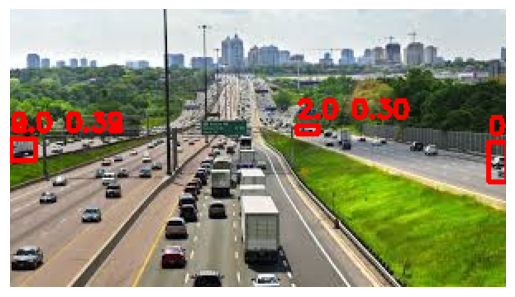

In [13]:
from ultralytics import YOLO

# Load the trained YOLO model
model = YOLO("/kaggle/working/Yolo11n_obj/train/weights/last.pt")

# Make predictions on a single image
results = model.predict(img)

# Display the results
for result in results:
    # Each result contains bounding boxes, labels, and scores
    boxes = result.boxes  # Bounding boxes
    for box in boxes:
        # Extract box coordinates, label, and confidence score
        x1, y1, x2, y2 = box.xyxy[0]  # Coordinates of the bounding box
        conf = box.conf[0]  # Confidence score
        cls = box.cls[0]  # Class label

        print(f"Detected {cls} with confidence {conf:.2f} at [{x1:.2f}, {y1:.2f}, {x2:.2f}, {y2:.2f}]")

# Optional: Display the image with predictions
import cv2
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread(img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Draw the bounding boxes on the image
for box in boxes:
    x1, y1, x2, y2 = box.xyxy[0].numpy()  # Convert to NumPy array for compatibility
    label = f"{box.cls[0]} {box.conf[0]:.2f}"  # Format label
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
    cv2.putText(image, label, (int(x1), int(y1) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Show the image with detections
plt.imshow(image)
plt.axis('off')
plt.show()


In [22]:
import cv2

# Load the trained model
model = YOLO("/kaggle/working/Yolo11n_obj/train/weights/last.pt")

# Load an image for prediction
img_path = "/kaggle/input/cars-dell-me/download (2).jpg"
img = cv2.imread(img_path)

# Make predictions and plot bounding boxes
results = model(img, visualize=True)


Saving runs/detect/predict/image0/stage0_Conv_features.png... (16/16)
Saving runs/detect/predict/image0/stage1_Conv_features.png... (32/32)
Saving runs/detect/predict/image0/stage2_C3k2_features.png... (32/64)
Saving runs/detect/predict/image0/stage3_Conv_features.png... (32/64)
Saving runs/detect/predict/image0/stage4_C3k2_features.png... (32/128)
Saving runs/detect/predict/image0/stage5_Conv_features.png... (32/128)
Saving runs/detect/predict/image0/stage6_C3k2_features.png... (32/128)
Saving runs/detect/predict/image0/stage7_Conv_features.png... (32/256)
Saving runs/detect/predict/image0/stage8_C3k2_features.png... (32/256)
Saving runs/detect/predict/image0/stage9_SPPF_features.png... (32/256)
Saving runs/detect/predict/image0/stage10_C2PSA_features.png... (32/256)
Saving runs/detect/predict/image0/stage11_Upsample_features.png... (32/256)
Saving runs/detect/predict/image0/stage12_Concat_features.png... (32/384)
Saving runs/detect/predict/image0/stage13_C3k2_features.png... (32/128

In [1]:
from ultralytics import YOLO

# Load the trained model
model = YOLO("Yolo11n.pt")

# Make a prediction on an image
results = model.predict(source="/kaggle/input/cars-dell-me/download (2).jpg", save=True)


ModuleNotFoundError: No module named 'ultralytics'

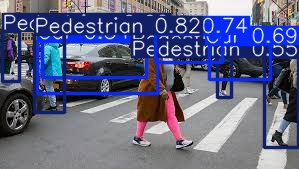

In [27]:
image = "/kaggle/working/runs/detect/predict3/download (2).jpg"

from PIL import Image

Image.open(image)

In [ ]:
# Import necessary libraries
from ultralytics import YOLO
import torch
from torch.optim import Adam
import torch.nn as nn
import yaml
import logging
from torch.optim.lr_scheduler import OneCycleLR

class AdvancedYOLOTrainer:
    def __init__(self, base_model='yolov8n.pt', freeze_backbone=True):
        self.model = YOLO(base_model)
        self.freeze_backbone = freeze_backbone
        self.setup_logging()

    def setup_logging(self):
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

    def freeze_layers(self):
        """Freeze backbone layers while keeping detection heads trainable"""
        # Freeze first n layers (backbone)
        for param in list(self.model.model.parameters())[:-10]:  # Keep last 10 layers trainable
            param.requires_grad = False
        
        self.logger.info("Backbone frozen, detection heads remain trainable")

    def setup_differential_learning_rates(self, optimizer):
        """Apply different learning rates to different layers"""
        parameters = []
        # Backbone layers (lower learning rate)
        backbone_params = list(self.model.model.parameters())[:-10]
        parameters.append({
            'params': backbone_params,
            'lr': 1e-5  # Very small learning rate for backbone
        })
        
        # Detection heads (higher learning rate)
        head_params = list(self.model.model.parameters())[-10:]
        parameters.append({
            'params': head_params,
            'lr': 1e-3  # Higher learning rate for detection heads
        })
        
        return Adam(parameters)

    def create_training_config(self):
        """Create advanced training configuration"""
        config = {
            'epochs': 100,
            'batch': 16,
            'imgsz': 640,
            'patience': 50,
            'device': [0],  # GPU device
            'project': 'YOLO_finetune',
            'name': 'preserved_knowledge',
            'optimizer': 'Adam',
            'lr0': 1e-3,  # Initial learning rate
            'lrf': 1e-4,  # Final learning rate
            
            # Advanced augmentation settings
            'hsv_h': 0.015,  # HSV-Hue augmentation
            'hsv_s': 0.7,    # HSV-Saturation augmentation
            'hsv_v': 0.4,    # HSV-Value augmentation
            'degrees': 5.0,   # Rotation
            'translate': 0.1, # Translation
            'scale': 0.5,    # Scaling
            'shear': 2.0,    # Shear
            'flipud': 0.5,   # Vertical flip probability
            'fliplr': 0.5,   # Horizontal flip probability
            'mosaic': 1.0,   # Mosaic probability
            'mixup': 0.1,    # Mixup probability
            
            # Regularization
            'weight_decay': 0.0005,
            'warmup_epochs': 3,
            'warmup_momentum': 0.8,
            'box': 7.5,      # Box loss gain
            'cls': 0.5,      # Classification loss gain
            'dfl': 1.5,      # DFL loss gain
            
            # Dataset handling
            'cache': False,   # Cache images for faster training
            'workers': 8,     # Number of worker threads
            'close_mosaic': 10  # Disable mosaic augmentation for final epochs
        }
        
        return config

    def create_custom_loss(self):
        """Create custom loss function to maintain COCO knowledge"""
        def knowledge_preservation_loss(predictions, targets, original_predictions):
            # Standard YOLOv8 loss
            standard_loss = self.model.loss_func(predictions, targets)
            
            # Knowledge distillation loss (soft targets from original model)
            kd_loss = nn.KLDivLoss()(
                torch.log_softmax(predictions / 2.0, dim=1),
                torch.softmax(original_predictions / 2.0, dim=1)
            )
            
            # Combine losses with weighting
            total_loss = standard_loss + 0.5 * kd_loss
            return total_loss
            
        return knowledge_preservation_loss

    def train(self, data_yaml_path):
        """Execute training with knowledge preservation"""
        # Load and verify dataset
        with open(data_yaml_path, 'r') as f:
            data_config = yaml.safe_load(f)
        
        self.logger.info("Starting advanced training with knowledge preservation...")
        
        # Freeze backbone if specified
        if self.freeze_backbone:
            self.freeze_layers()
        
        # Get training configuration
        training_config = self.create_training_config()
        
        # Create custom loss function
        custom_loss = self.create_custom_loss()
        
        # Start training with custom configuration
        results = self.model.train(
            data=data_yaml_path,
            **training_config,
            exist_ok=True
        )
        
        self.logger.info("Training completed. Saving model...")
        self.model.save('preserved_knowledge_model.pt')
        
        return results

    def validate(self, val_data):
        """Validate model on both COCO-style and custom dataset images"""
        # Validation on COCO-style images
        coco_metrics = self.model.val(split='val')
        
        # Validation on custom dataset
        custom_metrics = self.model.val(data=val_data)
        
        return {
            'coco_metrics': coco_metrics,
            'custom_metrics': custom_metrics
        }

# Usage example
if __name__ == "__main__":
    # Initialize trainer
    trainer = AdvancedYOLOTrainer(base_model='yolov8n.pt', freeze_backbone=True)
    
    # Train model
    results = trainer.train('path_to_your_data.yaml')
    
    # Validate on both COCO and custom data
    validation_results = trainer.validate('path_to_validation_data.yaml')
    
    # Save final model
    trainer.model.save('final_model.pt')